In [1]:
import numpy as np
import math
from GRAPE import *
import matplotlib.pyplot as plt
from qiskit import Aer, execute

In [2]:
H = math.sqrt(0.5)*np.array([1,1,1,-1]).reshape(2,2)
X = np.array([0,1,1,0]).reshape(2,2)
Y = np.array([0,-1j,1j,0]).reshape(2,2)
Z = np.array([1,0,0,-1]).reshape(2,2)
U = np.linalg.eig(H)[1].conj().T

CZ = np.eye(4)
CZ[3][3] = -1
CCZ = np.eye(8)
CCZ[7][7] = -1

U1 = np.kron(np.kron(X,U),np.eye(2))
V1 = CCZ
U1_ = U1.conj().T

U2 = np.kron(np.kron(X,U),np.eye(2))
V2 = np.kron(CZ,np.eye(2))
U2_ = U2.conj().T


U3 = np.kron(np.kron(np.eye(2),U),np.eye(2))
V3 = np.kron(np.eye(2),CZ)
U3_ = U3.conj().T

U4 = np.kron(np.kron(np.eye(2),U),np.eye(2))
V4 = np.kron(CZ,np.eye(2)) @ np.kron(np.eye(2),CZ)
U4_ = U4.conj().T

U5 = np.kron(np.kron(np.eye(2),X @ U),np.eye(2))
V5 = CCZ
U5_ = U5.conj().T

J = np.zeros((3, 3))
J[0][1] = 0.1385
J[1][2] = 0.01304
J[0][2] = 0.00148

[[0.     +0.j 0.1385 +0.j 0.00148+0.j]
 [0.     +0.j 0.     +0.j 0.01304+0.j]
 [0.     +0.j 0.     +0.j 0.     +0.j]]


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.j[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.j[i][j] * self.t

distance: 1.838741 ; time: 555.08
distance: 4.950181 ; time: 862.74
distance: 2.205378 ; time: 848.97
distance: 1.204813 ; time: 595.28
distance: 2.099675 ; time: 455.34
distance: 1.165193 ; time: 398.98
distance: 0.686662 ; time: 462.77
distance: 1.202691 ; time: 558.95
distance: 0.517069 ; time: 664.53
distance: 10.445315 ; time: 937.99
distance: 4.191729 ; time: 270.46
distance: 6.90831 ; time: 731.71
distance: 4.70395 ; time: 393.96
distance: 1.995076 ; time: 776.56
distance: 11.148881 ; time: 838.0
distance: 1.40425 ; time: 506.35
distance: 2.988586 ; time: 387.25
distance: 3.57181 ; time: 709.51
distance: 1.377191 ; time: 387.41
distance: 0.726525 ; time: 513.86
distance: 0.431057 ; time: 631.98
distance: 7.282076 ; time: 848.95
distance: 8.474676 ; time: 711.25
distance: 1.212614 ; time: 877.23
distance: 4.754159 ; time: 413.52
distance: 1.099856 ; time: 624.73
distance: 1.961461 ; time: 568.51
distance: 0.805633 ; time: 581.99
distance: 2.112424 ; time: 753.45
distance: 4.43734

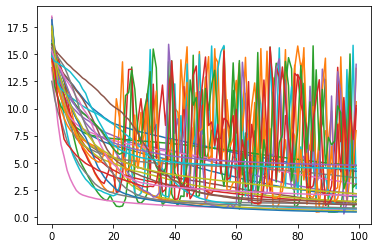

In [7]:
n = 30
m = 100
k = 6

descents = [GradientDescent(U3_, k) for _ in range(n)]

for descent in descents:
    descent.noise = 1
    descent.randomize_params()
    descent.set_j(J)

print(descents[0].gates[1].j)

losses = [descent.descend(steps=m, track_distance=True, time_sensitive=True) for descent in descents]

for loss in losses:
    plt.plot(np.real(loss))
for descent in descents:
    descent.make_times_positive()
    print("distance:", descent.distance.round(6).real, "; time:", descent.time.round(2))

In [8]:
descent = descents[18]
descent.distance

(1.377191075505002+0j)

In [ ]:
loss = descent.descend(steps=2000, track_distance=True)
plt.plot(np.real(loss))

C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)


In [ ]:
print("distance:", descent.distance.round(6).real, "; time:", descent.time.round(2))
descent.to_text("./Oleg/Ud3.txt")